In [22]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

In [23]:
class Layer:

    def __init__(self):
        pass
    
    def forward(self, input):
        return input
    def backward(self, input, grad_output):
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [24]:
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad

In [25]:
class LReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        lrelu_forward = np.maximum(0.01*input,input)
        return lrelu_forward
    
    def backward(self, input, grad_output):
        lrelu_grad=np.zeros(input.shape)
        for i in range(input.shape[0]):
            for j in range(input.shape[1]):
                if input[i,j]>0:
                    lrelu_grad[i,j] = 1
                else:
                    lrelu_grad[i,j] = 0.01
        return grad_output*lrelu_grad

In [26]:
class tanh(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        tanh_forward = np.tanh(input)
        return tanh_forward
    
    def backward(self, input, grad_output):
        tanh_grad = 1-np.tanh(input)**2
        return grad_output*tanh_grad

In [27]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy
def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [28]:
class Dropout(Layer):
    def __init__(self, input_units, output_units,p, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        self.p = p
        self.input_units = input_units
        self.output_units = output_units
        t = np.random.random()
        self.t = t
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        np.random.seed(int(self.t)*1000)
        index = np.random.permutation(len(input))
        a = np.ones((len(input),self.output_units))
        for i in index[:int(self.p*len(input))]:
            a[i,:] = 0           
        
        
        return (np.dot(input,self.weights) + self.biases)*a
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        np.random.seed(int(self.t)*1000)
        index = np.random.permutation(len(input))
        a = np.ones((len(input),self.output_units))
        for i in index[:int(self.p*len(input))]:
            a[i,:] = 0     
        grad_input = np.dot(grad_output, self.weights.T)*a
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [29]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

Importing and normaizing the data

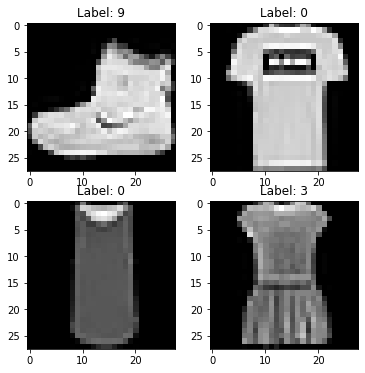

In [30]:
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
%matplotlib inline
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

Section-3 Q-1(a) using 0-hidden layers

Epoch 99
Train accuracy: 0.86966
Test accuracy: 0.8415


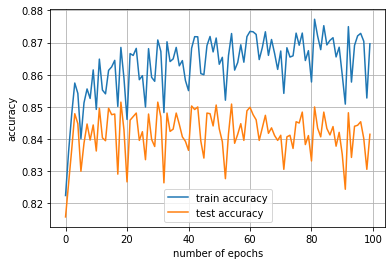

In [10]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q1(b) 1-hidden layer

Epoch 99
Train accuracy: 0.9676
Test accuracy: 0.8795


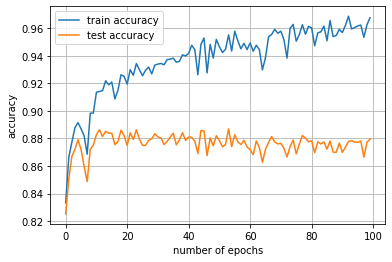

In [11]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q1(c) 2-hidden layer

Epoch 99
Train accuracy: 0.95664
Test accuracy: 0.8739


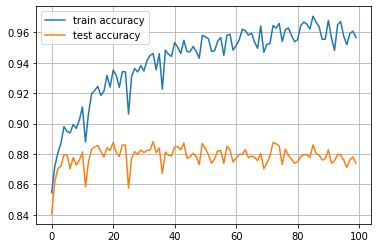

In [12]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q2 Tanh() activation

Epoch 99
Train accuracy: 0.94108
Test accuracy: 0.8734


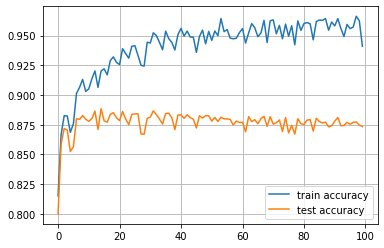

In [31]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(Dense(128,128))
network.append(tanh())
network.append(Dense(128,128))
network.append(tanh())
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q2 Leaky Relu  

Epoch 99
Train accuracy: 0.96792
Test accuracy: 0.8806


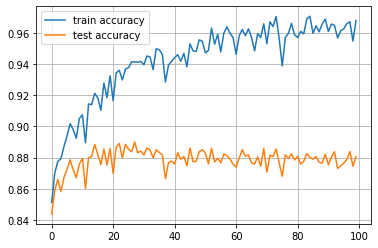

In [32]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(Dense(128,128))
network.append(LReLU())
network.append(Dense(128,128))
network.append(LReLU())
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q3 Dropout Layers 

Epoch 99
Train accuracy: 0.9005
Test accuracy: 0.8346


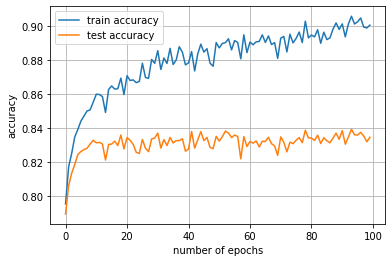

In [33]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(ReLU())
network.append(Dropout(128,128,.05))
network.append(ReLU())
network.append(Dropout(128,128,.05))
network.append(ReLU())
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q4 training on un-normaized data

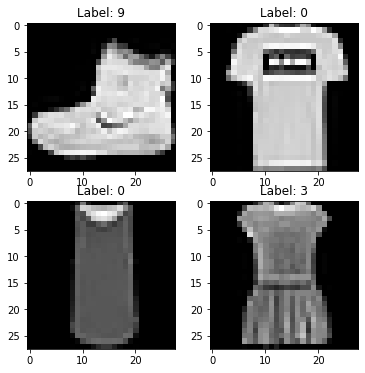

In [34]:
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
%matplotlib inline
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # normalize x
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

Epoch 99
Train accuracy: 0.09954
Test accuracy: 0.1023


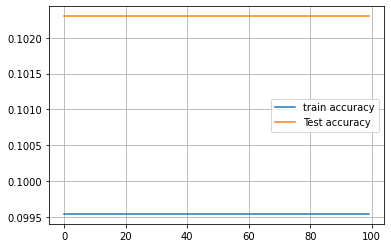

In [35]:
network = []
network.append(Dense(X_train.shape[1],128))
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='Test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Section-3 Q5 CNN

In [52]:
import tensorflow as tf # tested with 1.14.0
import numpy as np # tested with 1.16.4
import matplotlib.pyplot as plt #tested with 3.0.3
from sklearn.metrics import classification_report # tested with 0.21.2l
from keras.layers import Dropout
# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "Fashion MNIST" data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# A good rule of thumb is to normalise input values - i.e. transform them to a
# scale of 0 to 1. Each element in this dataset is a pixel value of 0 to 255, so
# we'll normalise / rescale these values.
x_train = x_train / 255.0
x_test = x_test / 255.0

# Map for human readable class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [37]:
model = []
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3, 3),strides=(1, 1),padding='valid',activation='relu',input_shape=(28, 28, 1))) 
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(1, 1),strides=(1, 1),padding='valid',activation='relu',input_shape=(26, 26, 1))) 
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(units=128,activation='relu'))
model.add(tf.keras.layers.Dense(units=128,activation='relu'))
model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        1056      
                                                                 
 flatten_1 (Flatten)         (None, 21632)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               2769024   
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,788,202
Trainable params: 2,788,202
No

In [38]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
history = model.fit(x_train, y_train,batch_size=256,epochs=100,validation_split=0.2,verbose=1) 

Epoch 1/100
188/188 [==============================] - 38s 201ms/step - loss: 0.5195 - accuracy: 0.8184 - val_loss: 0.3428 - val_accuracy: 0.8802
Epoch 2/100
188/188 [==============================] - 38s 204ms/step - loss: 0.3033 - accuracy: 0.8909 - val_loss: 0.2959 - val_accuracy: 0.8929
Epoch 3/100
188/188 [==============================] - 38s 204ms/step - loss: 0.2450 - accuracy: 0.9089 - val_loss: 0.2612 - val_accuracy: 0.9043
Epoch 4/100
188/188 [==============================] - 38s 205ms/step - loss: 0.2071 - accuracy: 0.9245 - val_loss: 0.2563 - val_accuracy: 0.9072
Epoch 5/100
188/188 [==============================] - 40s 214ms/step - loss: 0.1712 - accuracy: 0.9374 - val_loss: 0.2763 - val_accuracy: 0.9028
Epoch 6/100
188/188 [==============================] - 43s 227ms/step - loss: 0.1483 - accuracy: 0.9459 - val_loss: 0.2564 - val_accuracy: 0.9103
Epoch 7/100
188/188 [==============================] - 41s 217ms/step - loss: 0.1232 - accuracy: 0.9546 - val_loss: 0.3069 -

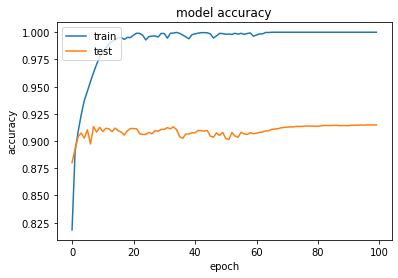

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

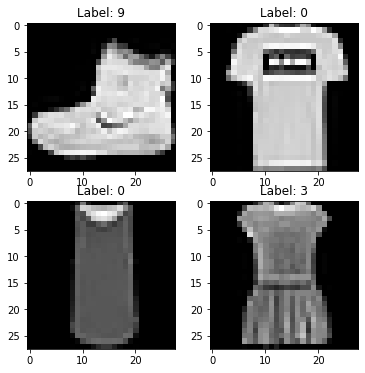

In [40]:
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
%matplotlib inline
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

Additionl effort (CNN with dropout)

In [54]:
model = []
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),padding='valid', activation='relu', input_shape=(28, 28, 1)))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(1, 1),strides=(1, 1),padding='valid',activation='relu',input_shape=(26, 26, 1))) 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128,  activation='relu' ))
model.add(Dropout(0.5))
model.add( tf.keras.layers.Dense( units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.compile( loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 dropout_2 (Dropout)         (None, 26, 26, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        1056      
                                                                 
 flatten_3 (Flatten)         (None, 21632)             0         
                                                                 
 dense_7 (Dense)             (None, 128)               2769024   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [55]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.2,verbose=1) 

Epoch 1/100
188/188 [==============================] - 51s 269ms/step - loss: 0.7196 - accuracy: 0.7379 - val_loss: 0.4391 - val_accuracy: 0.8429
Epoch 2/100
188/188 [==============================] - 51s 269ms/step - loss: 0.4596 - accuracy: 0.8356 - val_loss: 0.3602 - val_accuracy: 0.8679
Epoch 3/100
188/188 [==============================] - 51s 270ms/step - loss: 0.4013 - accuracy: 0.8547 - val_loss: 0.3219 - val_accuracy: 0.8827
Epoch 4/100
188/188 [==============================] - 51s 270ms/step - loss: 0.3623 - accuracy: 0.8676 - val_loss: 0.3083 - val_accuracy: 0.8870
Epoch 5/100
188/188 [==============================] - 51s 271ms/step - loss: 0.3377 - accuracy: 0.8759 - val_loss: 0.2987 - val_accuracy: 0.8909
Epoch 6/100
188/188 [==============================] - 51s 269ms/step - loss: 0.3198 - accuracy: 0.8818 - val_loss: 0.3013 - val_accuracy: 0.8949
Epoch 7/100
188/188 [==============================] - 50s 269ms/step - loss: 0.3001 - accuracy: 0.8884 - val_loss: 0.2907 -

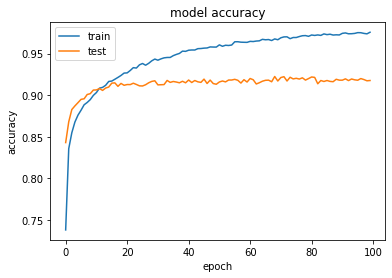

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Section-3 Q6 best mlp architecture (learning rate = 0.01)

In [46]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.05):
        # A dense layer is a layer which performs a learned affine transformation:
        # f(x) = <W*x> + b
        
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        # Perform an affine transformation:
        # f(x) = <W*x> + b
        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input


Epoch 99
Train accuracy: 0.9842
Test accuracy: 0.8913


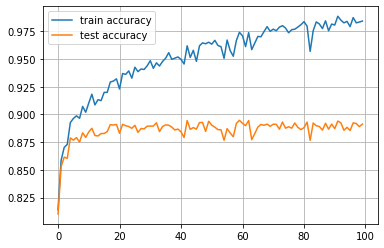

In [42]:
network = []
network.append(Dense(X_train.shape[1],128*2))
network.append(Dense(128*2,128*2))
network.append(ReLU())
network.append(Dense(128*2,128))
network.append(ReLU())
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,128))
network.append(ReLU())
network.append(Dense(128,64))
network.append(ReLU())
network.append(Dense(64,64))
network.append(ReLU())
network.append(Dense(64,64))
network.append(ReLU())
network.append(Dense(64,64))
network.append(ReLU())
network.append(Dense(64,32))
network.append(ReLU())
network.append(Dense(32,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

Effect of Width on model performance

MLP with 1-hidden layer and width = 32

Epoch 99
Train accuracy: 0.92088
Test accuracy: 0.8624


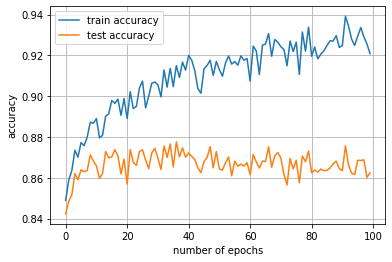

In [47]:
network = []
network.append(Dense(X_train.shape[1],32))
network.append(Dense(32,32))
network.append(ReLU())
network.append(Dense(32,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

MLP with 1-hidden layer and width = 64



Epoch 99
Train accuracy: 0.9481
Test accuracy: 0.8719


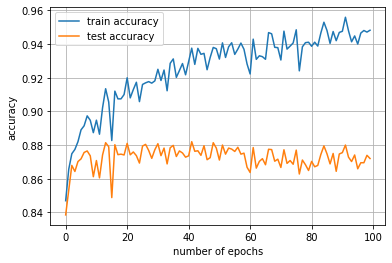

In [48]:
network = []
network.append(Dense(X_train.shape[1],64))
network.append(Dense(64,64))
network.append(ReLU())
network.append(Dense(64,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

MLP with 1-hidden layer and width = 256

Epoch 99
Train accuracy: 0.97302
Test accuracy: 0.88


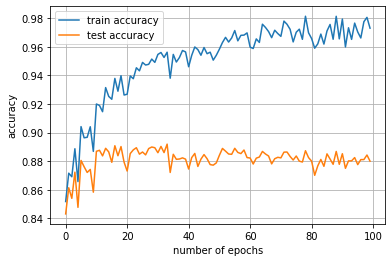

In [49]:
network = []
network.append(Dense(X_train.shape[1],256))
network.append(Dense(256,256))
network.append(ReLU())
network.append(Dense(256,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


MLP with 1-hidden layer and width = 512

Epoch 99
Train accuracy: 0.98698
Test accuracy: 0.8877


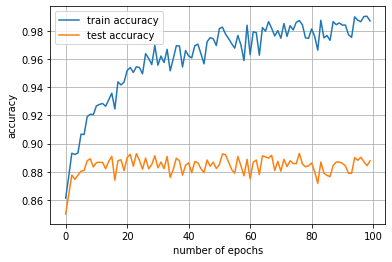

In [50]:
network = []
network.append(Dense(X_train.shape[1],512))
network.append(Dense(512,512))
network.append(ReLU())
network.append(Dense(512,10))
def forward(network, X):
    # Compute activations of all network layers by applying them sequentially.
    # Return a list of activations for each layer. 
    
    activations = []
    input = X
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations
def predict(network,X):
    # Compute network predictions. Returning indices of largest Logit probability
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)
def train(network,X,y):
    # Train our network on a given batch of X and y.
    # We first need to run forward to get all layer activations.
    # Then we can run layer.backward going from last to first layer.
    # After we have called backward for all layers, all Dense layers have already made one gradient step.
    
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output
train_log = []
val_log = []
for epoch in range(100):
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Test accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='test accuracy')
    plt.xlabel('number of epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()